In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


In [77]:
def load_ons_data(years_range):
    file_path = "nltuk198020213.xlsx"
    all_dfs = []

    # Générer les noms des feuilles (ex: 1980-1982, 1981-1983, ..., 2016-2018)
    sheets_to_load = [f"{year}-{year+2}" for year in years_range]

    for sheet_name in sheets_to_load:
        try:
            # Lire la feuille en sautant les premières lignes non pertinentes
            df = pd.read_excel(file_path, sheet_name=sheet_name, header=None, skiprows=5)

            # Trouver la colonne vide qui sépare hommes et femmes
            empty_col = df.columns[df.isnull().all()].tolist()
            if not empty_col:
                continue
            split_col = empty_col[0]

            # Extraire les données pour hommes (avant la colonne vide)
            males_df = df.iloc[:, :split_col].dropna(how='all')
            males_df.columns = ["age", "mx", "qx", "lx", "dx", "ex"]
            males_df["sex"] = "male"

            # Extraire les données pour femmes (après la colonne vide)
            females_df = df.iloc[:, split_col+1:split_col+7].dropna(how='all')
            females_df.columns = ["age", "mx", "qx", "lx", "dx", "ex"]
            females_df["sex"] = "female"

            # Ajouter l'année de référence (début de la période)
            year = int(sheet_name.split("-")[0])
            for df_part in [males_df, females_df]:
                df_part["year"] = year
                all_dfs.append(df_part)

        except Exception as e:
            print(f"Erreur avec la feuille {sheet_name}: {e}")

    # Concaténer toutes les données
    final_df = pd.concat(all_dfs, ignore_index=True)
    return final_df

# Charger les données de 1980 à 2018 (périodes 1980-1982 à 2016-2018)
years = range(1980, 2019)  # 2016+2 = 2018
df_qx = load_ons_data(years)

# Aperçu des données
print(df_qx.head())

   age        mx        qx       lx    dx     ex   sex  year
0  age        mx        qx       lx    dx     ex  male  1980
1    0  0.012902   0.01282   100000  1282  70.81  male  1980
2    1   0.00087  0.000869    98718  85.8  70.73  male  1980
3    2  0.000528  0.000528  98632.2  52.1  69.79  male  1980
4    3  0.000401  0.000401  98580.1  39.6  68.83  male  1980


In [78]:
# Filter the age and year range to match the simulated data
ages = np.arange(60, 91)
years = np.arange(1980, 2019)

# Filter real data to the right age range
df_filtered = df_qx[df_qx["age"].isin(ages) & df_qx["year"].isin(years)]

# Group by age and year and take the mean of mx across sexes
df_avg_mx = df_filtered.groupby(["age", "year"])["mx"].mean().unstack()

# Reindex to ensure exact same shape and order as simulated df_mx
df_avg_mx = df_avg_mx.reindex(index=ages, columns=years)

# Final result: df_avg_mx is same shape and format as df_mx
df_avg_mx.head()


year,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
age,,,,,,,,,,,,,,,,,,,,,
60,0.014605,0.014537,0.014256,0.01408,0.013871,0.013583,0.01313,0.012718,0.012352,0.011911,...,0.007039,0.006869,0.006726,0.006634,0.006679,0.006643,0.006594,0.006457,0.006344,0.006585
61,0.015721,0.015405,0.015418,0.015391,0.015273,0.015093,0.014752,0.014373,0.013891,0.01343,...,0.007571,0.007474,0.007383,0.007337,0.007249,0.007214,0.007154,0.007114,0.006938,0.007164
62,0.017473,0.017239,0.016934,0.017055,0.016856,0.016615,0.016254,0.015755,0.015343,0.014669,...,0.008077,0.008122,0.008058,0.008018,0.00794,0.007911,0.007855,0.007845,0.007802,0.008082
63,0.019451,0.01903,0.018846,0.018582,0.018517,0.018138,0.017832,0.017335,0.016996,0.016466,...,0.00893,0.008677,0.008672,0.008596,0.008699,0.008714,0.008736,0.008686,0.008519,0.008771
64,0.021405,0.021288,0.020563,0.020368,0.0199,0.020068,0.01962,0.019394,0.018995,0.018455,...,0.009845,0.009515,0.009307,0.009391,0.009458,0.009484,0.009465,0.009319,0.009196,0.009371


In [79]:
# -------------------------
# Étape 2 : VAP à partir des taux 2018
# -------------------------
def get_qx(mx):
    return 1 - np.exp(-mx)

def ax_due(qx, i=0.02):
    px = 1 - qx
    lx = np.cumprod(np.insert(px, 0, 1))[:-1]
    v = 1 / (1 + i)
    return np.sum(lx * v ** np.arange(len(qx)))

def Ax(qx, i=0.02):
    px = 1 - qx
    lx = np.cumprod(np.insert(px, 0, 1))[:-1]
    dx = lx * qx
    v = 1 / (1 + i)
    return np.sum(dx * v ** np.arange(1, len(qx)+1))

qx_2018 = get_qx(df_mx[2018].values)
print("VAP rente due à 60 ans :", ax_due(qx_2018))
print("VAP capital décès à 60 ans :", Ax(qx_2018))


VAP rente due à 60 ans : 23.37228571877905
VAP capital décès à 60 ans : 0.002251783866407963


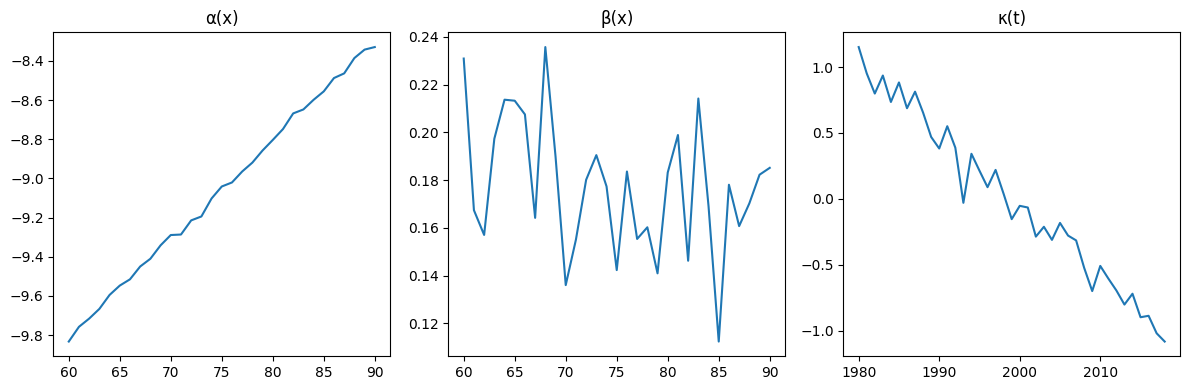

In [80]:
# -------------------------
# Étape 3 : Modèle de Lee-Carter
# -------------------------
def lee_carter(mx, ages, years):
    log_mx = np.log(mx)
    alpha = np.mean(log_mx, axis=1)
    Z = log_mx - alpha[:, None]
    U, S, Vt = np.linalg.svd(Z, full_matrices=False)
    beta = U[:, 0]
    kappa = S[0] * Vt[0, :]
    return alpha, beta, kappa

alpha, beta, kappa = lee_carter(mx, ages, years)

# Affichage
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(ages, alpha)
plt.title("α(x)")

plt.subplot(1, 3, 2)
plt.plot(ages, beta)
plt.title("β(x)")

plt.subplot(1, 3, 3)
plt.plot(years, kappa)
plt.title("κ(t)")
plt.tight_layout()
plt.show()

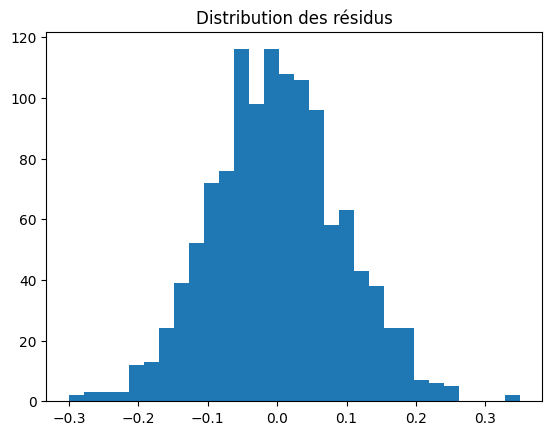

In [81]:
residuals = log_mx - (alpha[:, None] + np.outer(beta, kappa))
plt.figure()
plt.hist(residuals.flatten(), bins=30)
plt.title("Distribution des résidus")
plt.show()

In [153]:
# -------------------------
# Étape 4 : Projection centrale sur 25 ans
# -------------------------
from statsmodels.tsa.ar_model import AutoReg

model_kappa = AutoReg(kappa, lags=1).fit()
kappa_proj = model_kappa.predict(start=len(kappa), end=len(kappa)+24)

# Projection des taux
years_proj = np.arange(2019, 2019+25)
log_mx_proj = alpha[:, None] + np.outer(beta, kappa_proj)
mx_proj = np.exp(log_mx_proj)

In [144]:
mx_proj.shape


(31, 26)

In [199]:
# -------------------------
# Étape 5 : log taux et espérance de vie cohortes 2010
# -------------------------
def get_cohort(mx_proj, start_year=2010, max_age=85):
    """Extraction robuste des taux de mortalité cohorte"""
    cohort = []
    current_age = 60

    for year_offset in range(25):
        current_year = start_year + year_offset
        age_idx = current_age + year_offset - 60
        year_idx = current_year - 2019

        if (0 <= age_idx < mx_proj.shape[0]) and (0 <= year_idx < mx_proj.shape[1]):
            cohort.append(mx_proj[age_idx, year_idx])
        else:
            cohort.append(0)  # Remplissage pour les données manquantes

    return np.array(cohort)

esp_vie_residuelle = ax_due(qx_proj_cohort)
print("Espérance de vie cohortelle (2010) :", esp_vie_residuelle)

Espérance de vie cohortelle (2010) : 13.840398210094056


In [200]:
# -------------------------
# Étape 6 : Espérance de vie périodique 2010
# -------------------------
qx_2010 = get_qx(df_mx[2010].values)
esp_vie_2010 = ax_due(qx_2010)
print("Espérance de vie périodique (2010) :", esp_vie_2010)

Espérance de vie périodique (2010) : 23.370002572561347


In [201]:
# -------------------------
# Étape 7 : Fonctions VAP (déjà définies plus haut)
# -------------------------
print("VAP (rente) avec taux projetés :", ax_due(qx_proj_cohort))
print("VAP (capital décès) avec taux projetés :", Ax(qx_proj_cohort))

VAP (rente) avec taux projetés : 13.840398210094056
VAP (capital décès) avec taux projetés : 0.0014012292143415562


In [202]:
# -------------------------
# Étape 8 : Choc de mortalité 20% entre 2020–2025
# -------------------------
mx_proj_shocked = mx_proj.copy()
for year in range(2020, 2026):
    idx = year - 2019
    if 0 <= idx < mx_proj.shape[1]:
        mx_proj_shocked[:, idx] *= 1.2

qx_proj_cohort_shocked = get_qx(get_cohort(mx_proj_shocked))
esp_vie_choc = ax_due(qx_proj_cohort_shocked)
print("Espérance de vie post-choc :", esp_vie_choc)
print("VAP rente post-choc :", ax_due(qx_proj_cohort_shocked))
print("VAP capital décès post-choc :", Ax(qx_proj_cohort_shocked))


Espérance de vie post-choc : 19.90570449144281
VAP rente post-choc : 19.90570449144281
VAP capital décès post-choc : 0.0012504114325158694


In [203]:
# -------------------------
# Étape 9 : Projections stochastiques (Monte Carlo)
# -------------------------
from statsmodels.tsa.arima.model import ARIMA

def simulate_kappa_paths(kappa, n_sims=1000, horizon=25):
    """Simule des chemins stochastiques pour kappa avec modèle ARIMA(1,1,0)"""
    model = ARIMA(kappa, order=(0,1,0)).fit()
    sim_paths = []

    for _ in range(n_sims):
        sim = model.simulate(horizon)
        sim_paths.append(sim)

    return np.array(sim_paths)

# Générer 1000 chemins de mortalité
kappa_sims = simulate_kappa_paths(kappa, n_sims=1000)
log_mx_sims = alpha[:, None, None] + beta[:, None, None] * kappa_sims[None, :, :]
mx_sims = np.exp(log_mx_sims)


In [204]:
log_mx_sims

array([[[ 1.74954425e+00,  1.72954767e+00,  1.72617456e+00, ...,
          1.84786181e+00,  1.89793647e+00,  1.89646316e+00],
        [ 1.73366190e+02,  1.73328619e+02,  1.73306029e+02, ...,
          1.73288917e+02,  1.73321051e+02,  1.73268324e+02],
        [ 3.17637572e+02,  3.17583645e+02,  3.17507708e+02, ...,
          3.17377535e+02,  3.17336619e+02,  3.17265282e+02],
        ...,
        [ 2.48046700e+02,  2.48051523e+02,  2.47985649e+02, ...,
          2.48298439e+02,  2.48226342e+02,  2.48230579e+02],
        [ 9.40066169e+00,  9.41840033e+00,  9.44030592e+00, ...,
          9.41419938e+00,  9.44858353e+00,  9.45155905e+00],
        [-1.81551778e+02, -1.81579095e+02, -1.81571496e+02, ...,
         -1.81707313e+02, -1.81697868e+02, -1.81714908e+02]],

       [[-1.36101810e+00, -1.37551442e+00, -1.37795971e+00, ...,
         -1.28974380e+00, -1.25344269e+00, -1.25451075e+00],
        [ 1.23050704e+02,  1.23023468e+02,  1.23007091e+02, ...,
          1.22994686e+02,  1.23017981e

In [205]:
mx_sims = np.exp(log_mx_sims)

In [182]:
mx_sims = np.exp(np.clip(log_mx_sims, None, 700))

In [206]:
mx_sims

array([[[5.75198063e+000, 5.63810305e+000, 5.61911717e+000, ...,
         6.34623554e+000, 6.67211211e+000, 6.66228924e+000],
        [1.95875350e+075, 1.88652686e+075, 1.84438734e+075, ...,
         1.81309464e+075, 1.87230232e+075, 1.77613932e+075],
        [8.87656159e+137, 8.41055171e+137, 7.79552772e+137, ...,
         6.84403202e+137, 6.56965348e+137, 6.11732224e+137],
        ...,
        [5.31267380e+107, 5.33835889e+107, 4.99802962e+107, ...,
         6.83348008e+107, 6.35814503e+107, 6.38514179e+107],
        [1.20963821e+004, 1.23128700e+004, 1.25855665e+004, ...,
         1.22612527e+004, 1.26901773e+004, 1.27279934e+004],
        [1.42254027e-079, 1.38420637e-079, 1.39476533e-079, ...,
         1.21763406e-079, 1.22918929e-079, 1.20842067e-079]],

       [[2.56399604e-001, 2.52709564e-001, 2.52092369e-001, ...,
         2.75341317e-001, 2.85520146e-001, 2.85215355e-001],
        [2.75576295e+053, 2.68171836e+053, 2.63815849e+053, ...,
         2.60563380e+053, 2.66704458e+

Dérive annuelle: -0.0587
Volatilité annuelle: 0.1557
Dernière valeur κ: -1.0808


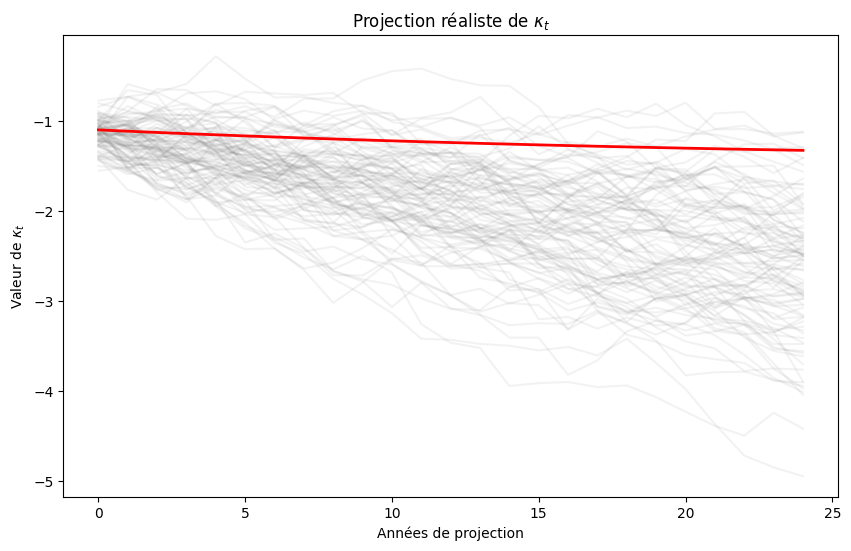

In [207]:
# -------------------------
# Correction du modèle de projection κ
# -------------------------
from statsmodels.tsa.arima.model import ARIMA

def simulate_kappa_paths(kappa, n_sims=1000, horizon=25):
    """Version corrigée avec modèle ARIMA(0,1,0) et dérive explicite"""
    # 1. Estimation du modèle
    model = ARIMA(kappa, order=(0,1,0), trend='t').fit()  # Random Walk with Drift

    # 2. Paramètres estimés
    drift = model.params[0]  # Dérive annuelle moyenne
    sigma = np.sqrt(model.params[1])  # Écart-type des résidus

    # 3. Simulation à partir de la dernière valeur observée
    last_kappa = kappa[-1]
    sim_paths = []

    for _ in range(n_sims):
        # Génération des chocs aléatoires
        shocks = np.random.normal(loc=drift, scale=sigma, size=horizon)

        # Intégration cumulative depuis last_kappa
        path = last_kappa + np.cumsum(shocks)
        sim_paths.append(path)

    return last_kappa,sigma,drift,np.array(sim_paths)

# Régénération des simulations
last_kappa,sigma,drift,kappa_sims = simulate_kappa_paths(kappa, n_sims=1000)

# -------------------------
# Vérification des paramètres
# -------------------------
print(f"Dérive annuelle: {drift:.4f}")
print(f"Volatilité annuelle: {sigma:.4f}")
print(f"Dernière valeur κ: {last_kappa:.4f}")

# -------------------------
# Visualisation corrigée
# -------------------------
plt.figure(figsize=(10, 6))
plt.plot(kappa_sims[:100, :].T, color='grey', alpha=0.1)
plt.plot(kappa_proj, color='red', linewidth=2)
plt.title("Projection réaliste de $\kappa_t$")
plt.xlabel("Années de projection")
plt.ylabel("Valeur de $\kappa_t$")
plt.show()

In [213]:
# -------------------------
# Étape 10 : Calcul des VAP stochastiques
# -------------------------
def stochastic_vap(mx_sims, n_proj=25, i=0.02):
    """Calcul robuste des VAP avec gestion des erreurs"""
    vap_annuity = []

    for sim in range(mx_sims.shape[1]):
        try:
            qx_cohort = get_qx(get_cohort(mx_sims[:, sim, :]))
            qx_truncated = qx_cohort[:n_proj]

            if len(qx_truncated) == n_proj:
                vap = ax_due(qx_truncated, i)
                if not np.isnan(vap):
                    vap_annuity.append(vap)

        except Exception as e:
            print(f"Erreur simulation {sim}: {e}")
            continue

    return np.array(vap_annuity)

# Nouveau calcul
vap_annuity_sims = stochastic_vap(mx_sims)


# -------------------------
# Métriques de risque
# -------------------------
def risk_metrics(vap_sims, confidence=0.95):
    """Calcule VaR et CVaR"""
    if len(vap_sims) == 0:
        return np.nan, np.nan  # Gestion des cas vides

    var = np.percentile(vap_sims, 100*(1 - confidence))
    cvar = vap_sims[vap_sims <= var].mean()
    return var, cvar

In [210]:
vap_annuity_sims = stochastic_vap(mx_sims)

In [211]:
vap_annuity_sims

array([ 9.91489411,  9.16223671,  9.16223671, 19.9139256 ,  9.16223671,
       19.9139256 , 19.9139256 ,  9.16223671,  9.16223671,  9.16223671,
       19.9139256 , 19.9139256 , 19.9139256 ,  9.16223671, 19.91326198,
       19.9139256 , 19.9139256 ,  9.16223671, 19.9139256 , 19.9139256 ,
       19.9139256 , 19.9139256 , 19.9139256 , 19.88989445, 19.9139256 ,
       19.9139256 , 19.9139256 , 19.9139256 , 19.9139256 , 19.9139256 ,
       19.9139256 ,  9.16223671,  9.16223671,  9.16223671,  9.16223671,
        9.16223671,  9.16223671, 19.91386705, 19.9139256 , 19.9139256 ,
       19.9139256 , 19.9139256 ,  9.16223671,  9.16223671,  9.16223671,
       19.9139256 ,  9.16223671,  9.16223671, 19.9139256 ,  9.16223671,
       19.9139256 , 19.9139256 , 19.9139256 , 19.9139256 ,  9.16223671,
        9.16223671, 19.9139256 ,  9.16223671, 19.9139256 , 19.9139256 ,
        9.16223671, 19.91357427, 19.9139256 ,  9.16223671, 19.9139256 ,
       19.9139256 , 19.9139256 , 19.9139256 ,  9.16223671,  9.16

VaR 95% rente : 9.16€
CVaR 95% rente : 9.16€
[[-1.35046607 -1.45845096 -1.18244783 ... -2.03131949 -2.03535475
  -2.00333108]
 [-1.18932474 -1.27407533 -1.60404387 ... -3.59561629 -3.85275246
  -4.01008719]
 [-1.05482423 -1.19635937 -1.28609922 ... -1.96279576 -1.95381357
  -1.81872237]
 ...
 [-1.06799075 -1.26634981 -1.32291539 ... -1.78934581 -2.09232581
  -2.31879623]
 [-1.29726302 -1.46750894 -1.74277409 ... -4.36165749 -4.55874104
  -4.75427043]
 [-1.09080306 -1.20321387 -1.28741688 ... -1.42845249 -1.38527953
  -1.45112748]]
[-1.09584594 -1.11031661 -1.12421756 -1.13757121 -1.15039913 -1.162722
 -1.1745597  -1.18593135 -1.19685529 -1.20734915 -1.21742985 -1.22711367
 -1.23641623 -1.24535255 -1.25393703 -1.26218354 -1.27010537 -1.27771532
 -1.28502566 -1.29204818 -1.29879422 -1.30527467 -1.31149998 -1.31748019
 -1.32322495]


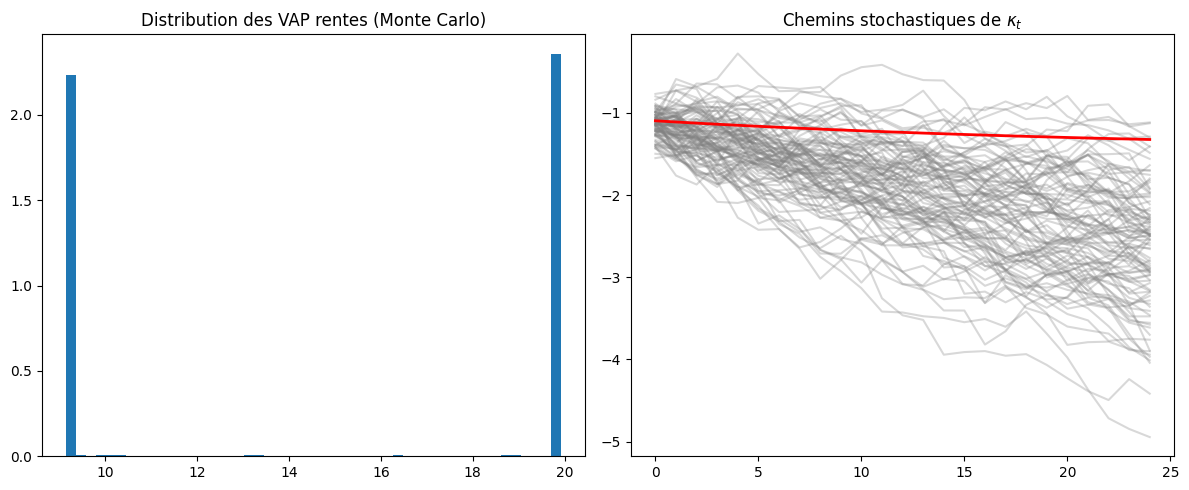

In [212]:
var_annuity, cvar_annuity = risk_metrics(vap_annuity_sims)
print(f"VaR 95% rente : {var_annuity:.2f}€")
print(f"CVaR 95% rente : {cvar_annuity:.2f}€")

# -------------------------
# Visualisation
# -------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(vap_annuity_sims, bins=50, density=True)
plt.title("Distribution des VAP rentes (Monte Carlo)")
plt.subplot(1, 2, 2)
vap_annuity_sims
plt.plot(kappa_sims[:100, :].T, color='grey', alpha=0.3)
plt.plot(kappa_proj, color='red', linewidth=2)
print(kappa_sims)
print(kappa_proj)
plt.title("Chemins stochastiques de $\kappa_t$")
plt.tight_layout()
plt.show()